In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Carica i dati
data = np.load(
    'data/0d890ad3184ded354855c291be64a07fe2e378fc/tensors/0d890ad3184ded354855c291be64a07fe2e378fc_serene_e2d1edf8-419c-45bf-8a59-0933c923e484.jpg_9_9_5_3.npy')

data.shape

(122, 478, 3)

In [7]:
from scipy.spatial import procrustes
from scipy.signal import savgol_filter


def smooth_trajectory(traj, window=15):
    """
    Applica un filtro di Savitzky-Golay per smussare la traiettoria.
    """
    smoothed = np.zeros_like(traj)
    for i in range(traj.shape[1]):
        for j in range(traj.shape[2]):
            smoothed[:, i, j] = savgol_filter(traj[:, i, j], window, 3)
    return smoothed


def rigid_align_sequence(data, reference_frame=None):
    """
    Stabilizza la sequenza (n_frames, n_points, 3) rispetto a un frame di riferimento.
    """
    if reference_frame is None:
        reference_frame = data[0]

    aligned = []
    for frame in data:
        mtx1, mtx2, _ = procrustes(reference_frame, frame)
        aligned.append(mtx2)
    return np.array(aligned)


data_rigid = rigid_align_sequence(data)
data_smooth = smooth_trajectory(data_rigid)

datasets = [data, data_rigid, data_smooth]

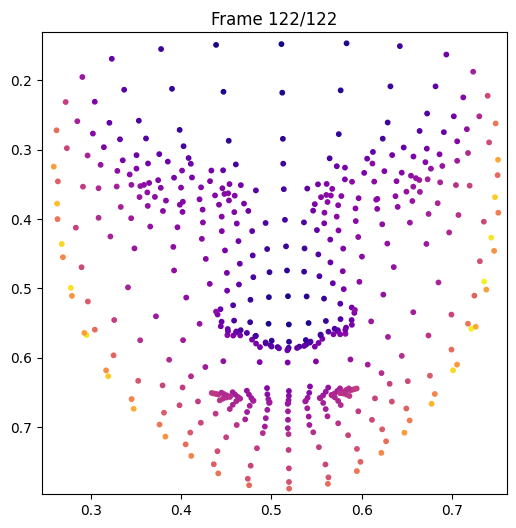

In [8]:


# Normalizzazione se necessaria
x_min, x_max = np.min(data[..., 0]), np.max(data[..., 0])
y_min, y_max = np.min(data[..., 1]), np.max(data[..., 1])
z_min, z_max = np.min(data[..., 2]), np.max(data[..., 2])

# Set up plot
fig, ax = plt.subplots(figsize=(6, 6))
scat = ax.scatter([], [], c=[], cmap='plasma', s=10, vmin=z_min, vmax=z_max)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.invert_yaxis()
ax.set_title("Facial 3D points over time")

# Funzione di inizializzazione
def init():
    scat.set_offsets(np.empty((0, 2)))  # evita l'IndexError
    scat.set_array(np.array([]))
    return scat,

# Funzione di aggiornamento
def update(frame):
    points = data[frame]
    scat.set_offsets(points[:, :2])       # x e y
    scat.set_array(points[:, 2])          # z -> colore
    ax.set_title(f"Frame {frame + 1}/{data.shape[0]}")
    return scat,

# Crea animazione
ani = animation.FuncAnimation(fig, update, frames=data.shape[0], init_func=init, blit=True)

# Salva la GIF
ani.save('face_motion.gif', writer='pillow', fps=15)


In [9]:
from scipy.special import expit  # sigmoid
import numpy as np

def encode_xyz_to_rgb(point_trajectory):
    """
    Input:
        point_trajectory: (n_frames, 3) -> [x, y, z] over time
    Output:
        rgb_encoded: (n_frames, 3) -> [r, g, b] over time
    """
    # Normalizza ogni dimensione tra 0 e 1
    pt_min = point_trajectory.min(axis=0)
    pt_max = point_trajectory.max(axis=0)
    normalized = (point_trajectory - pt_min) / (pt_max - pt_min + 1e-8)

    # Applica funzione non lineare (sigmoid)
    rgb_encoded = expit(6 * (normalized - 0.5))  # 'sharpen' sigmoid
    return rgb_encoded


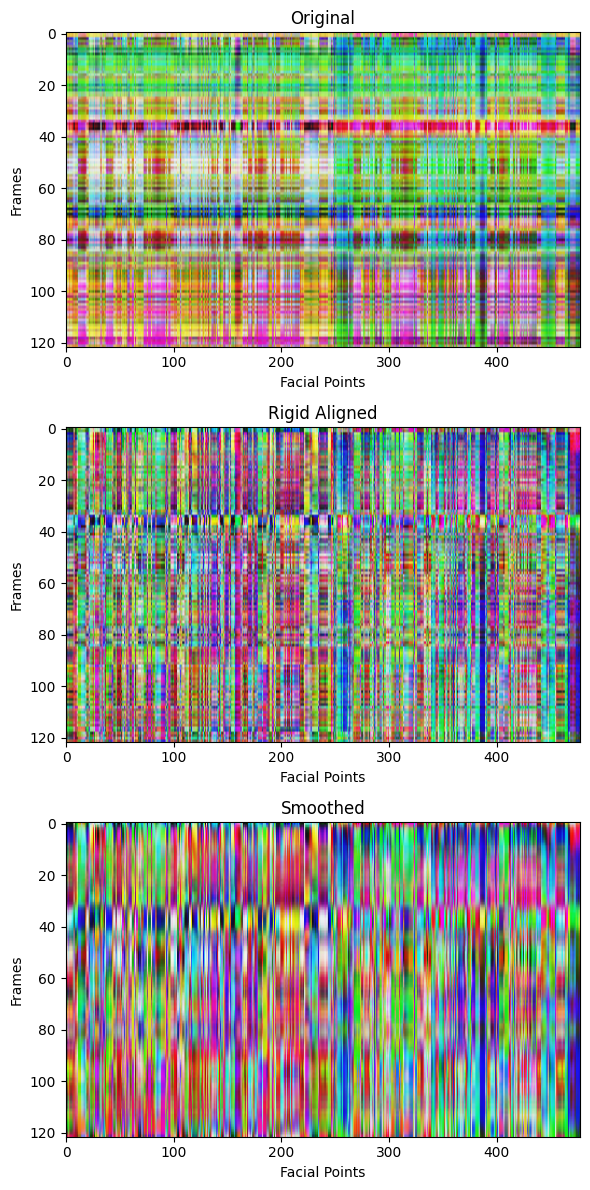

In [10]:
import matplotlib.pyplot as plt

encoded_data = []
titles = ["Original", "Rigid Aligned", "Smoothed"]

for data in datasets:
    rgb_encoded_per_point = []
    for i in range(data.shape[1]):  # per ogni punto (478)
        point_trajectory = data[:, i, :]  # (126, 3)
        rgb = encode_xyz_to_rgb(point_trajectory)  # (126, 3)
        rgb_encoded_per_point.append(rgb)

    rgb_data = np.stack(rgb_encoded_per_point, axis=1)  # (126, 478, 3)
    rgb_image = (rgb_data * 255).astype(np.uint8)
    encoded_data.append(rgb_image)

plt.figure(figsize=(6, 12))  # Altezza maggiore, larghezza ridotta

for i, rgb_img in enumerate(encoded_data):
    plt.subplot(3, 1, i + 1)
    plt.imshow(rgb_img, aspect='auto')
    plt.title(titles[i])
    plt.xlabel("Facial Points")
    plt.ylabel("Frames")

plt.tight_layout()
plt.show()



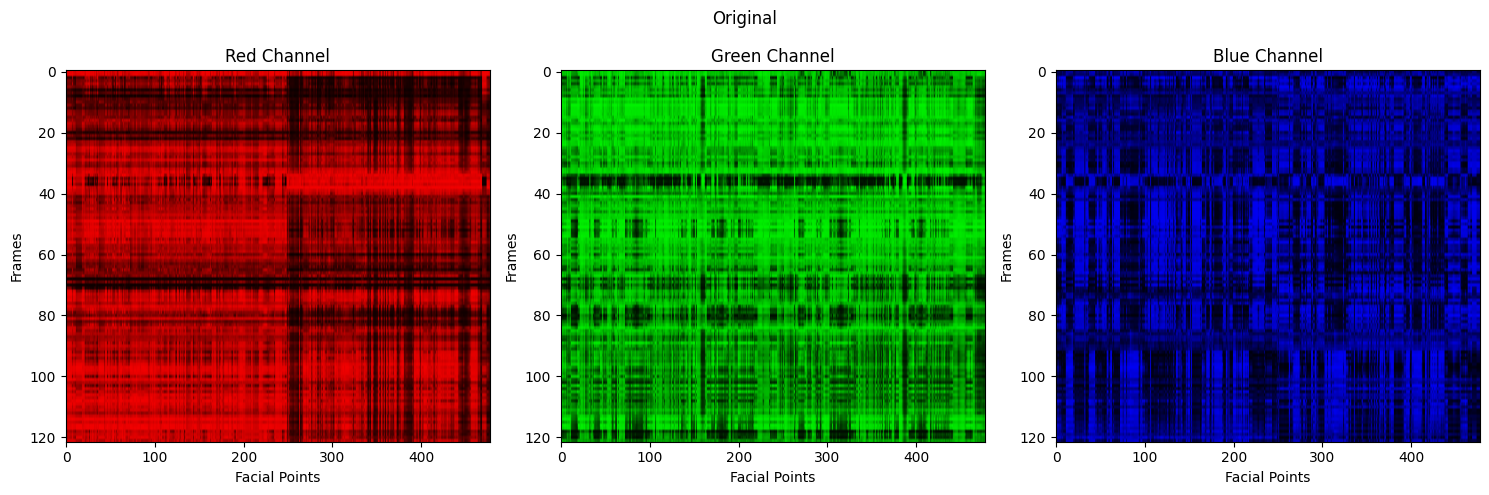

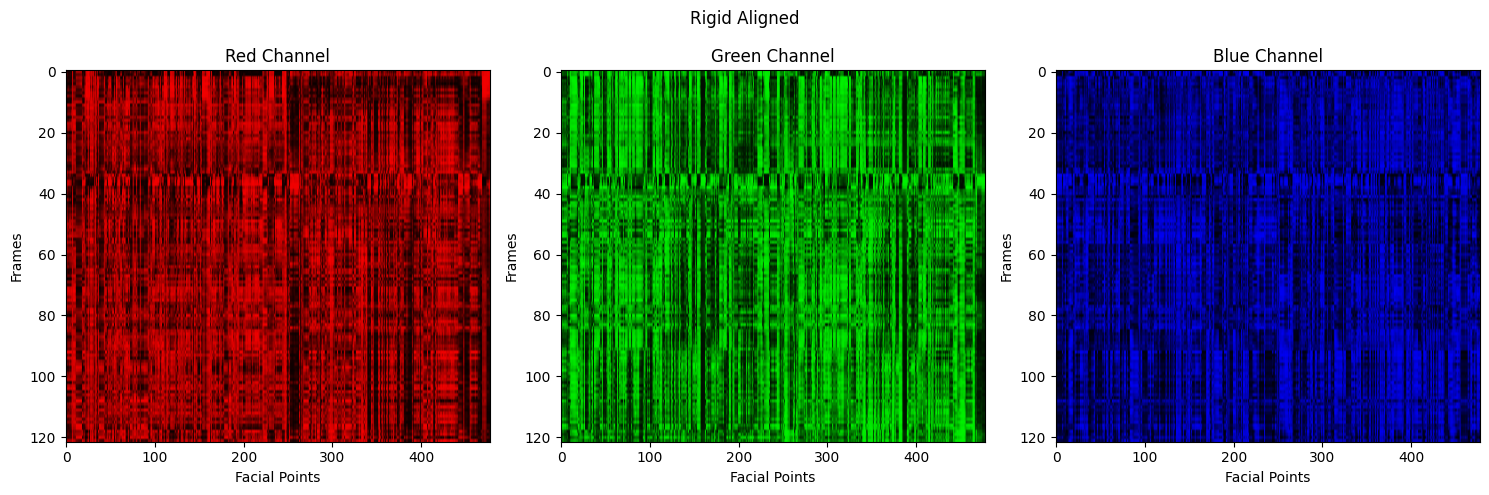

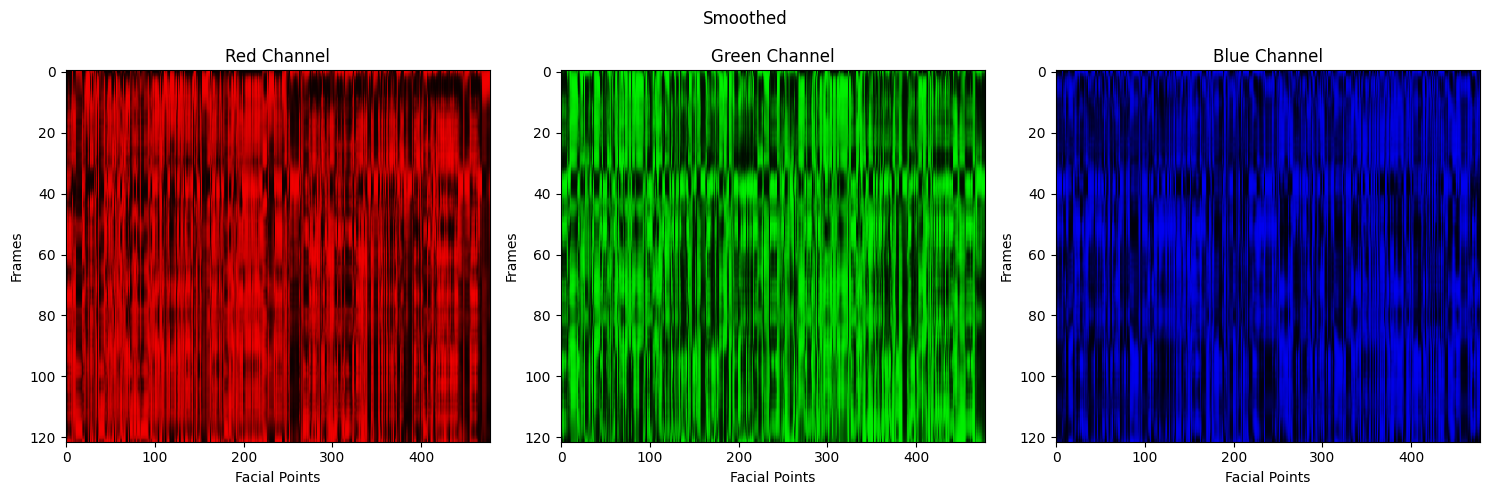

In [11]:
import matplotlib.pyplot as plt

channel_titles = ['Red Channel', 'Green Channel', 'Blue Channel']

def plot_rgb_channels(rgb_img, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title)

    for idx, ax in enumerate(axes):
        channel = np.zeros_like(rgb_img)
        channel[..., idx] = rgb_img[..., idx]
        ax.imshow(channel, aspect='auto')
        ax.set_title(channel_titles[idx])
        ax.set_xlabel("Facial Points")
        ax.set_ylabel("Frames")

    plt.tight_layout()
    plt.show()

# Applica la funzione per ogni immagine
for i, rgb_img in enumerate(encoded_data):
    plot_rgb_channels(rgb_img, titles[i])
